# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto

1. Descarga los datos y haz el remuestreo por una hora.

2. Analiza los datos.

3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.

4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de datos

Los datos se almacenan en el archivo /datasets/taxi.csv.  Descarga el conjunto de datos

- El número de pedidos está en la columna num_orders.

## Evaluación del proyecto

Hemos definido los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio.

Esto es en lo que se fijarán los revisores al examinar tu proyecto:

- ¿Seguiste todos los pasos de las instrucciones?
- ¿Cómo preparaste los datos?
- ¿Qué modelos e hiperparámetros consideraste?
- ¿Conseguiste evitar la duplicación del código?
- ¿Cuáles fueron tus hallazgos?
- ¿Mantuviste la estructura del proyecto?
- ¿Mantuviste el código limpio?
- Ya tienes tus hojas informativas y los resúmenes de los capítulos, por lo que todo está listo para continuar con el proyecto.

# Importar librerías

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats as st
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from IPython.display import display
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
import joblib
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics import tsaplots
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Importamos el archivo

In [149]:
data=pd.read_csv('datasets/taxi.csv')

In [150]:
data['datetime']=pd.to_datetime(data['datetime'])
data.set_index('datetime',inplace=True)
data.sort_index(inplace=True)
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


# Preparación de datos

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [152]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Ausentes

In [153]:
print('Ausentes:',data.isna().sum())

Ausentes: num_orders    0
dtype: int64


In [154]:
print('Ausentes:',data.index.isna().sum())

Ausentes: 0


## Duplicados

In [155]:
print('Duplicados:',data.index.duplicated().sum())

Duplicados: 0


# Remuestreo

In [156]:
data=data.resample('1H').sum()
data_model=data.copy()


In [157]:
data['rolling_mean']=data.rolling(12).mean()

# Análisis

In [158]:
data_analysis=data.copy()

<Axes: xlabel='datetime'>

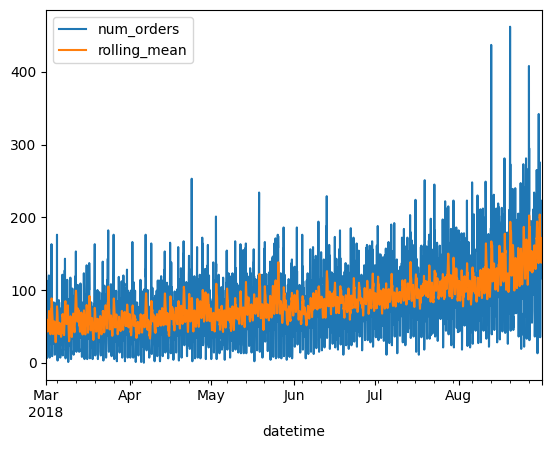

In [159]:
data_analysis.plot()

<Axes: xlabel='month'>

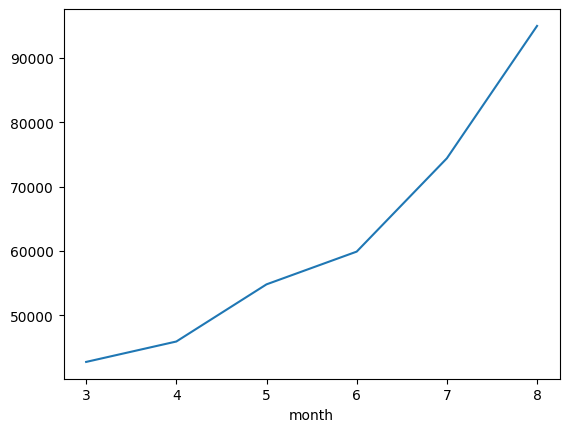

In [160]:
data_analysis['month']=data_analysis.index.month
data_1=data_analysis.groupby('month')['num_orders'].sum()
data_1.plot()

Podemos ver que el número de pedido de taxis aumenta a lo largo del año teniendo una subida para el més de agosto.

<Axes: xlabel='hour'>

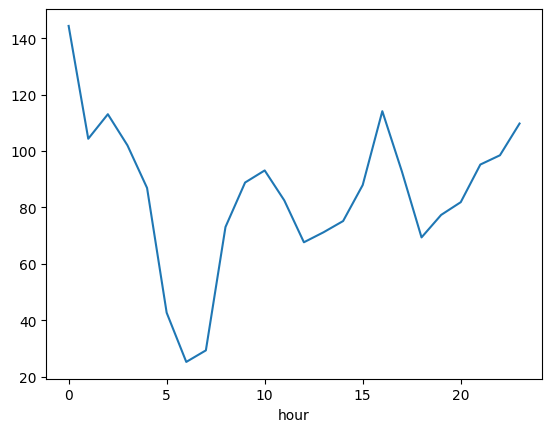

In [161]:
data_analysis['hour']=data_analysis.index.hour
data_2=data_analysis.groupby('hour')['num_orders'].mean()
data_2.plot()

Podemos ver que los pedidos de servicio inician con un valor aproximado de 140 pedidos a las 0, depues cae el número de servicios y vuelve a aumentar para las 10, posteriormente vuelve a aumentar a las 15 y a las 24.

## Tendencias y estacionalidad

In [162]:
data_seasonal=data_analysis['num_orders']
data_seasonal.head()

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
Freq: H, Name: num_orders, dtype: int64

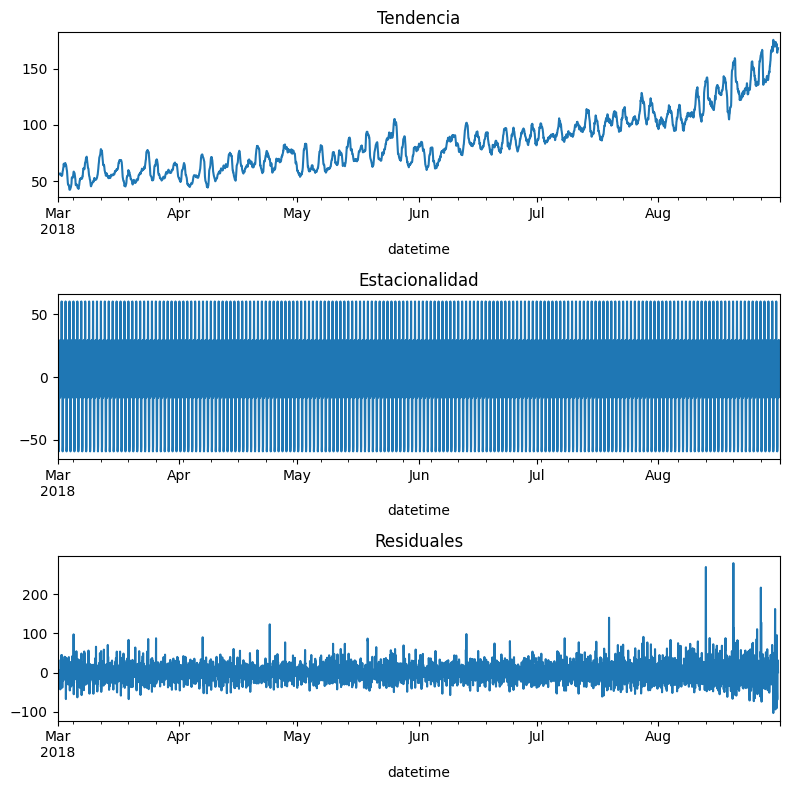

In [163]:
descomposed = seasonal_decompose(data_seasonal)

plt.figure(figsize=(8, 8))

plt.subplot(311)
descomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
descomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
descomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()

Podemos ver que la tendencia es el aumento de los serviciós hacia el final del año. No es posible ver con claridad la estacionalidad, la veremos más a detalle posteriormente. El residuo es ruido, no representa nada relevante.


# Análisis de la estacionalidad para los primeros 8 días de agosto.

<Axes: xlabel='datetime'>

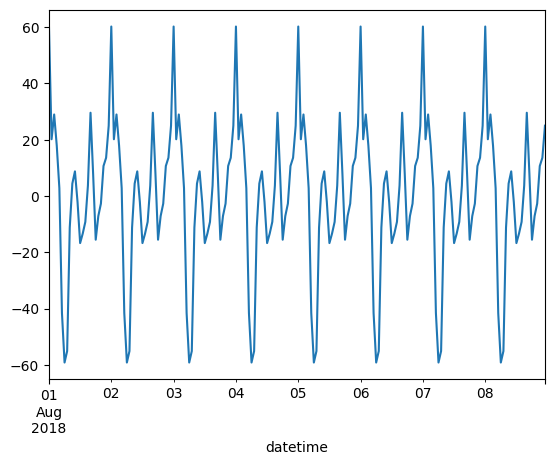

In [164]:
descomposed.seasonal['2018-08-01':'2018-08-08'].plot()


Podemos ver que los servicios tienen la misma distribución cada día, se repite el análisis que hicimos de los picos que tienen los servicios a distintas horas como hora **0, 10, 15 y 24**. Sin embargo, esto no garantiza si es o no estacional, posteriormente probaremos esto.

# Diferencias de series temporales

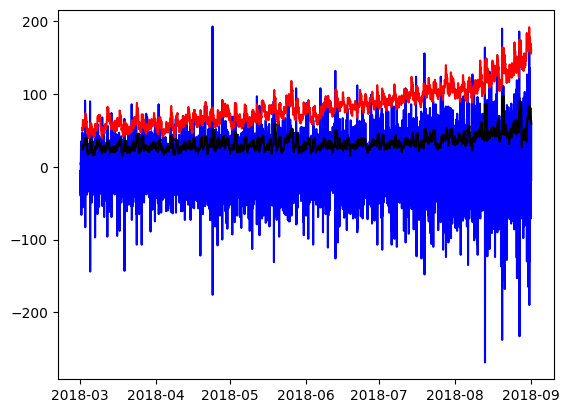

In [165]:
data_shifted=data.copy()

data_shifted-=data_shifted.shift()
data_shifted.drop(['rolling_mean'],axis=1,inplace=True)
data_shifted['mean'] = data_analysis['num_orders'].rolling(20).mean()
data_shifted['std'] = data_analysis['num_orders'].rolling(20).std()
plt.plot(data_shifted['num_orders'],color='blue')
plt.plot(data_shifted['mean'],color='red')
plt.plot(data_shifted['std'],color='black')
plt.show()

Al diferenciar la serie, esta intenta volverse estacional, sin embargo, según la gráfica no lo es debido a que su media movil cambia, evidenciando una tendencia.

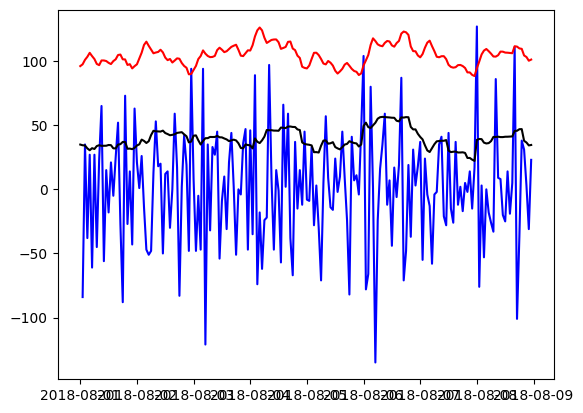

In [166]:
data_shifted=data['2018-08-01':'2018-08-08'].copy()
data_shifted-=data_shifted.shift()
data_shifted.drop(['rolling_mean'],axis=1,inplace=True)
data_shifted['mean'] = data_analysis['num_orders'].rolling(20).mean()
data_shifted['std'] = data_analysis['num_orders'].rolling(20).std()
plt.plot(data_shifted['num_orders'],color='blue')
plt.plot(data_shifted['mean'],color='red')
plt.plot(data_shifted['std'],color='black')
plt.show()


## Prueba Augmented Dikey-Fuller test

$H0=$ **La serie temporal es no estacionaria**

$H1=$ **La serie temporal es estacionaria**

In [167]:
data.drop('rolling_mean',axis=1,inplace=True)

In [168]:
# Realizar la prueba ADF
result = adfuller(data)

# Extraer los resultados
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Imprimir los resultados
print(f'Estadística ADF: {adf_statistic}')
print(f'Valor p: {p_value}')
print('Valores críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')
if p_value < 0.05:
    print('La serie temporal es estacionaria.')
else:
    print('La serie temporal es no estacionaria.')

Estadística ADF: -3.0689242890279576
Valor p: 0.0289400514026128
Valores críticos:
   1%: -3.431842162413052
   5%: -2.8621993540813637
   10%: -2.567120978470452
La serie temporal es estacionaria.


Al tener un p valor menor al 5% de significancia, rechazamos la hipotesis nula y la serie temporal es estacionaria.

## Prueba KPSS

In [169]:
kpss_stat,p_value,lags,critical_values=kpss(data)

print(f'Estadística KPSS: {kpss_stat}')
print(f'Valor p: {p_value}')
print('Valores críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')
if p_value < 0.05:
    print('La serie temporal es no estacionaria.')
else:
    print('La serie temporal es estacionaria.')

Estadística KPSS: 10.913353384602186
Valor p: 0.01
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
La serie temporal es no estacionaria.


C:\Users\Santiago\AppData\Local\Temp\ipykernel_1224\2388207966.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat,p_value,lags,critical_values=kpss(data)


Al tener un p valor menor al 5% de significancia, rechazamos la hipotesis nula y la serie temporal es no estacionaria. Al tener la prueba adfuller como estacionaria y la KPSS como no estacionaria, debemos hacer la prueba con la diferencia de series.

In [170]:
data_diff=data-data.shift(1)

# Metodología Box - Jenkins

In [171]:
# Realizar la prueba ADF
result = adfuller(data_diff.dropna())

# Extraer los resultados
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Imprimir los resultados
print(f'Estadística ADF: {adf_statistic}')
print(f'Valor p: {p_value}')
print('Valores críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')
if p_value < 0.05:
    print('La serie temporal es estacionaria.')
else:
    print('La serie temporal es no estacionaria.')

Estadística ADF: -15.793234257410537
Valor p: 1.0958776746509003e-28
Valores críticos:
   1%: -3.431842843698785
   5%: -2.8621996550511697
   10%: -2.56712113869159
La serie temporal es estacionaria.


In [172]:
kpss_stat,p_value,lags,critical_values=kpss(data_diff.dropna())

print(f'Estadística KPSS: {kpss_stat}')
print(f'Valor p: {p_value}')
print('Valores críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')
if p_value < 0.05:
    print('La serie temporal es no estacionaria.')
else:
    print('La serie temporal es estacionaria.')

Estadística KPSS: 0.07209700232043853
Valor p: 0.1
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
La serie temporal es estacionaria.


C:\Users\Santiago\AppData\Local\Temp\ipykernel_1224\2381404354.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat,p_value,lags,critical_values=kpss(data_diff.dropna())


## Análisis de autocorrelación

In [173]:
autocorr_lag1=data_shifted['num_orders'].autocorr(lag=1)
print(autocorr_lag1)
autocorr_lag3=data_shifted['num_orders'].autocorr(lag=3)
print(autocorr_lag3)
autocorr_lag6=data_shifted['num_orders'].autocorr(lag=6)
print(autocorr_lag6)
autocorr_lag12=data_shifted['num_orders'].autocorr(lag=12)
print(autocorr_lag12)
autocorr_lag24=data_shifted['num_orders'].autocorr(lag=24)
print(autocorr_lag24)

-0.24068215419011738
-0.1002393589989371
-0.10870723043957155
0.10051621621199372
0.3409446824166542


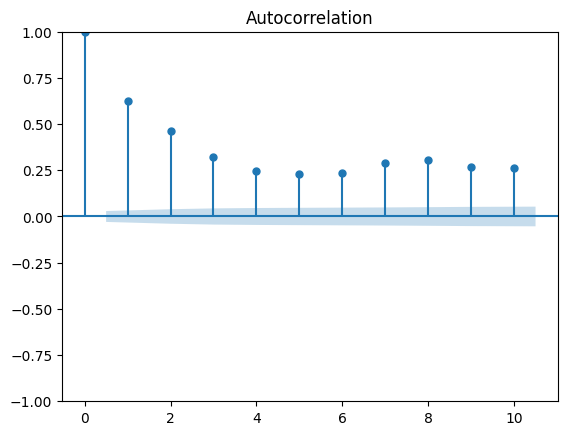

In [174]:
fig1=tsaplots.plot_acf(data,lags=10)
plt.show()

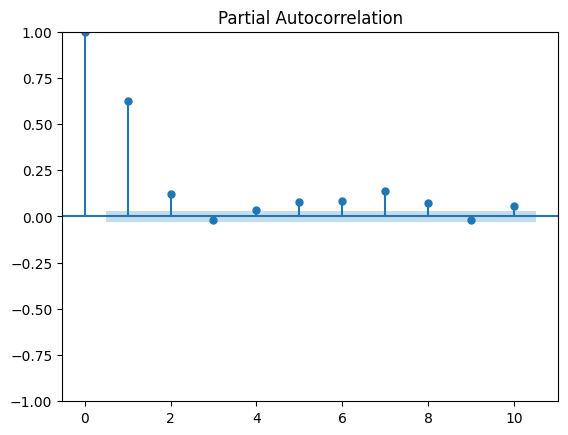

In [175]:
fig2=tsaplots.plot_pacf(data,lags=10)
plt.show()

En el diagrama de autocorrelación podemos ver que todos los retrazos con un 95% de probabilidad impactan los datos, y el diagrama de autocorrelación parcial nos deja ver que eliminando los retrazos cortos, con 95% de probabilidad, estos afectan la serie temporal, en ambos casos se ve el impacto de esta correlación.

En la ACF, la primera autocorrelación es significativa y además parece ser que los valores de la PACF disminuyen en forma oscilatoria. El proceso de identificacion a partir de los correlogramas muestrales sugieren un ARIMA(0,1,1) o ARIMA(0,1,0).

## ARIMA

Con base a los resultados de los diagramas de autocorrelación y las pruebas KPSS y adfuller, usaremos la serie temporal con diferencia que tiene estacionalidad para obtener mejores resultados.

In [176]:
seed=12345
train_arima,test_arima=train_test_split(data_diff,
                            test_size=0.10,shuffle=False,random_state=seed)

In [177]:
# Ajuste del modelo ARIMA
def ARIMA_model(data_train,data_test,order):
    order = order  # Puedes definir p, d, q basado en el análisis de los gráficos ACF y PACF
    start_index = len(data_train)
    end_index = start_index + len(data_test) - 1
    model = ARIMA(data_train, order=order)
    arima_model = model.fit()
    predictions = arima_model.predict(start=start_index, end=end_index, typ='levels')
    
    # Calcular el error de pronóstico
    error = mean_squared_error(data_test, predictions)**0.5
    return error,predictions
    

In [178]:
# Visualizar los resultados
def resultados(train,test,predictions):
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Predictions')
    plt.legend()
    plt.show()

## IMA(0,1,1)

In [179]:
order=(0,1,1)
print(f'Resultado: {ARIMA_model(train_arima,test_arima,order)[0]}')

Resultado: 58.8564814404731


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


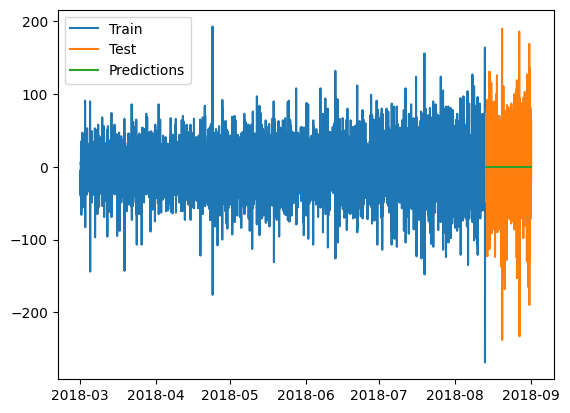

In [180]:
resultados(train_arima,test_arima,ARIMA_model(train_arima,test_arima,order)[1])

## I(0,1,0)

In [181]:
order=(0,1,0)
print(f'Resultado: {ARIMA_model(train_arima,test_arima,order)[0]}')

Resultado: 64.67286282143665


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


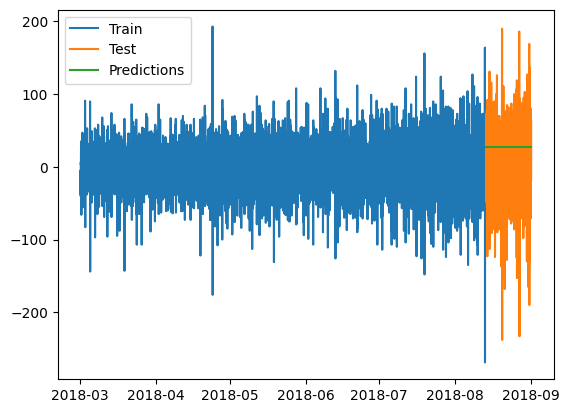

In [182]:
resultados(train_arima,test_arima,ARIMA_model(train_arima,test_arima,order)[1])

## ARMA(1,0,1)

In [183]:
order=(1,0,1)
print(f'Resultado: {ARIMA_model(train_arima,test_arima,order)[0]}')

Resultado: 58.85803312266175


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


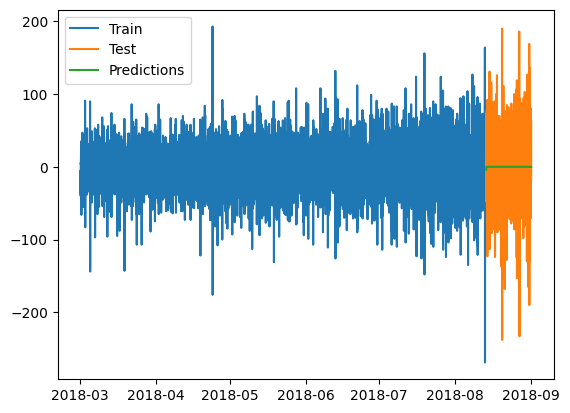

In [184]:
resultados(train_arima,test_arima,ARIMA_model(train_arima,test_arima,order)[1])

Al utilizar el modelo ARIMA, obtuvimos mejores resultados con el IMA y el ARMA que tuvieron resultados similares de 58 de error, lo cual no es suficiente para la implementación de estos modelos. Posteriormente veremos modelos de regresión con potenciación del gradiente creando nuevas categorías.

## Auto ARIMA

In [185]:
# Aplicar auto_arima
modelo_auto_arima = auto_arima(data_diff.dropna(), seasonal=True, m=12, trace=True)

# Resumen del modelo
print(modelo_auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=14.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=44886.781, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=44473.028, Time=1.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=44341.919, Time=1.42 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=44884.782, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=44355.438, Time=0.48 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=7.02 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=43532.955, Time=5.76 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=43318.259, Time=4.24 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=23.26 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=11.82 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=9.49 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=18.74 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=22.48 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC

In [186]:
# Ajustar el modelo ARIMA
order = (0, 0, 1)  # ARIMA(0,0,1)
seasonal_order = (1, 0, 2, 12)  # Estacional ARIMA(1,0,2) con periodo de estacionalidad 12
start_index = len(train_arima)
end_index = start_index + len(test_arima) - 1
model = ARIMA(train_arima, order=order, seasonal_order=seasonal_order, trend='c')  # 'c' indica un término de intercepto
results = model.fit()

predictions = results.predict(start=start_index, end=end_index, typ='levels')
    
# Calcular el error de pronóstico
error = mean_squared_error(test_arima, predictions)**0.5
print('Error:',error) 

Error: 53.592801994404084


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


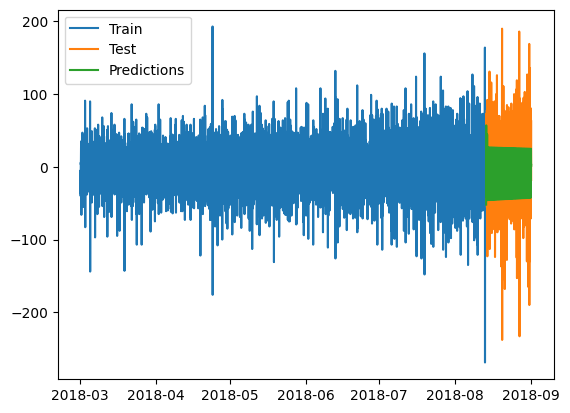

In [187]:
resultados(train_arima,test_arima,predictions)

El auto Arima mejoró significativamente nuestros resultados, sin embargo, no pasan la prueba de mínimo 48 de error.

## Entrenamiento

In [188]:
#Funcion para agregar características
def make_features(data,max_lag,rolling_mean_size):
  data['year']=data.index.year
  data['month']=data.index.month
  data['day']=data.index.day
  data['hour']=data.index.hour

  for lag in range(1,max_lag+1):
    data[f'lag_{lag}']=data['num_orders'].shift(lag)
  data['rolling_mean']=data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [189]:
make_features(data_model,4,12)

In [190]:
data_model.head(5)

,num_orders,year,month,day,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,4,66.0,71.0,85.0,124.0,NaN


## Separamos el dataset

In [191]:
seed=12345
train,test=train_test_split(data_model,
                            test_size=0.10,shuffle=False,random_state=seed)
train.dropna(inplace=True)
features_train=train.drop(['num_orders'],axis=1)
features_test=test.drop(['num_orders'],axis=1)
target_train=train['num_orders']
target_test=test['num_orders']


## Regresión Lineal

In [192]:
model_1=LinearRegression()
model_1.fit(features_train,target_train)
pred_1=model_1.predict(features_test)
rmse_1=mean_squared_error(target_test,pred_1)**0.5
print('RMSE:',rmse_1)

RMSE: 52.636608586271166


## CatBoost

In [193]:
grid = {'iterations': [50],
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [194]:
model_2=CatBoostRegressor(loss_function='RMSE',random_seed=seed)
grid_search_cat=model_2.grid_search(grid, X=features_train,y=target_train, shuffle=False,verbose=3)
best_params=grid_search_cat['params']
print(best_params)

0:	learn: 77.0792900	test: 112.1458202	best: 112.1458202 (0)	total: 1.54ms	remaining: 75.3ms
1:	learn: 75.1842979	test: 109.9632572	best: 109.9632572 (1)	total: 2.92ms	remaining: 70.1ms
2:	learn: 73.2915404	test: 107.6256615	best: 107.6256615 (2)	total: 3.97ms	remaining: 62.1ms
3:	learn: 71.4723982	test: 105.4139746	best: 105.4139746 (3)	total: 5ms	remaining: 57.6ms
4:	learn: 69.7041829	test: 103.2702460	best: 103.2702460 (4)	total: 6.03ms	remaining: 54.3ms
5:	learn: 67.9920822	test: 101.4731295	best: 101.4731295 (5)	total: 7.07ms	remaining: 51.8ms
6:	learn: 66.4185490	test: 99.7339042	best: 99.7339042 (6)	total: 7.68ms	remaining: 47.2ms
7:	learn: 64.8697406	test: 97.7652245	best: 97.7652245 (7)	total: 8.74ms	remaining: 45.9ms
8:	learn: 63.3470914	test: 95.8297316	best: 95.8297316 (8)	total: 9.78ms	remaining: 44.6ms
9:	learn: 61.8406629	test: 94.0681920	best: 94.0681920 (9)	total: 11ms	remaining: 44ms
10:	learn: 60.4032389	test: 92.1644081	best: 92.1644081 (10)	total: 12.1ms	remaining:

41:	learn: 22.3075560	test: 36.2310330	best: 36.2310330 (41)	total: 78.4ms	remaining: 14.9ms
42:	learn: 22.2003741	test: 36.1058234	best: 36.1058234 (42)	total: 80ms	remaining: 13ms
43:	learn: 22.1335168	test: 35.9188948	best: 35.9188948 (43)	total: 81.3ms	remaining: 11.1ms
44:	learn: 22.0387606	test: 35.8206720	best: 35.8206720 (44)	total: 82.7ms	remaining: 9.19ms
45:	learn: 21.9841523	test: 35.7252436	best: 35.7252436 (45)	total: 83.9ms	remaining: 7.29ms
46:	learn: 21.9069536	test: 35.5942080	best: 35.5942080 (46)	total: 85ms	remaining: 5.43ms
47:	learn: 21.8773229	test: 35.4389097	best: 35.4389097 (47)	total: 86.4ms	remaining: 3.6ms
48:	learn: 21.8383671	test: 35.3366901	best: 35.3366901 (48)	total: 87.6ms	remaining: 1.79ms
49:	learn: 21.8124874	test: 35.2814679	best: 35.2814679 (49)	total: 88.8ms	remaining: 0us

bestTest = 35.28146787
bestIteration = 49

0:	learn: 77.0958890	test: 112.1897300	best: 112.1897300 (0)	total: 1.49ms	remaining: 73.2ms
1:	learn: 75.2091006	test: 110.02734

In [195]:
#Evaluamos el modelo

best_model_1 = CatBoostRegressor(**best_params)
best_model_1.fit(features_train, target_train)
pred_2 = best_model_1.predict(features_test)
rmse_2 = mean_squared_error(target_test, pred_2)**0.5
print('RMSE: ', rmse_2)

0:	learn: 36.7660925	total: 3.6ms	remaining: 177ms
1:	learn: 35.0854686	total: 5.94ms	remaining: 142ms
2:	learn: 33.6994248	total: 8.45ms	remaining: 132ms
3:	learn: 32.5195273	total: 10.8ms	remaining: 125ms
4:	learn: 31.4533217	total: 13ms	remaining: 117ms
5:	learn: 30.5113691	total: 15.6ms	remaining: 115ms
6:	learn: 29.5989709	total: 17.9ms	remaining: 110ms
7:	learn: 29.0292544	total: 20.5ms	remaining: 107ms
8:	learn: 28.4648180	total: 23.2ms	remaining: 106ms
9:	learn: 28.0392488	total: 25.9ms	remaining: 104ms
10:	learn: 27.5214388	total: 28.2ms	remaining: 99.8ms
11:	learn: 26.9854869	total: 30.7ms	remaining: 97.2ms
12:	learn: 26.7141236	total: 33.1ms	remaining: 94.3ms
13:	learn: 26.3813439	total: 36.1ms	remaining: 92.8ms
14:	learn: 25.9489394	total: 38.4ms	remaining: 89.6ms
15:	learn: 25.6590197	total: 40.7ms	remaining: 86.4ms
16:	learn: 25.4320606	total: 43.1ms	remaining: 83.6ms
17:	learn: 25.1799659	total: 45.4ms	remaining: 80.6ms
18:	learn: 24.9773805	total: 47.7ms	remaining: 77.9

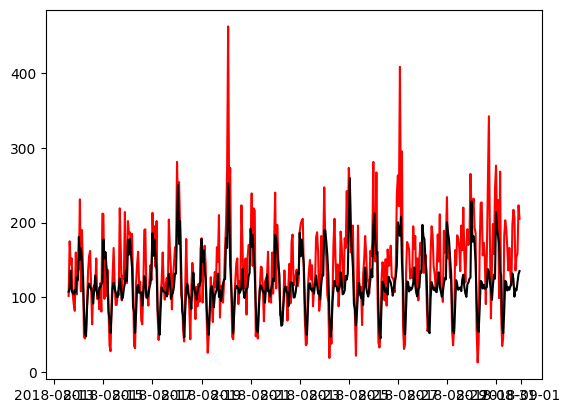

In [196]:
pred_2=pd.DataFrame(pred_2,index=target_test.index)
#plt.plot(target_train,color='blue')
plt.plot(target_test,color='red')
plt.plot(pred_2,color='black')
plt.show()

In [197]:
joblib.dump(best_model_1,'models/best_model_1.joblib')

['models/best_model_1.joblib']

## Light_gbm

In [198]:
#Entrenamos el modelo
model_lg =LGBMRegressor(random_state=seed,force_col_wise=True)


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 30, 50]
}
grid_2 = GridSearchCV(model_lg, param_grid, cv=3, scoring='r2')

grid_2.fit(features_train, target_train)

print("Mejores parametros:", grid_2.best_params_)
print("Mejores parametros: {:.2f}".format(grid_2.best_score_))
#Evaluamos el modelo
best_model = grid_2.best_estimator_
pred_3 = best_model.predict(features_test)
rmse_3 = mean_squared_error(target_test, pred_3)**0.5
print("RMSE:",rmse_3)

[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 87.904203
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 79.502461
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 2642, number of used features: 8
[LightGBM] [Info] Start training from score 67.661998
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 87.904203
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 79.502461
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 2642, number of

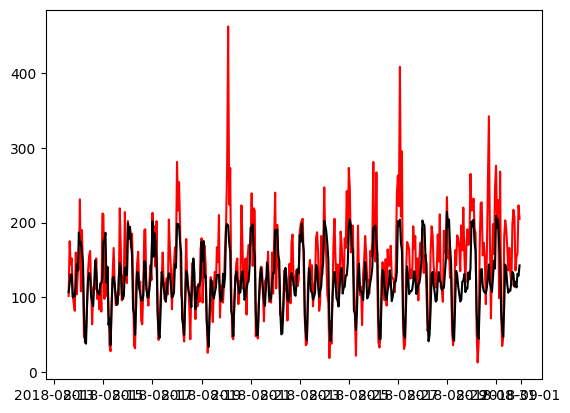

In [199]:
pred_3=pd.DataFrame(pred_3,index=target_test.index)
#plt.plot(target_train,color='blue')
plt.plot(target_test,color='red')
plt.plot(pred_3,color='black')
plt.show()

In [200]:
joblib.dump(grid_2,'models/grid_2.joblib')

['models/grid_2.joblib']

## XGBoost

In [201]:
#Entrenamos los datos
dtrain=xgb.DMatrix(features_train,label=target_train)
dtest=xgb.DMatrix(features_test,label=target_test)
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10
model_4 = xgb.train(param, dtrain, num_round, evallist)

#Evaluamos el modelo
pred_4 = model_4.predict(dtest)
xg_rmse=mean_squared_error(target_test,pred_4)**0.5
print("RMSE:",xg_rmse)


[0]	train-rmse:31.64120	eval-rmse:72.75792
[1]	train-rmse:29.12945	eval-rmse:60.27824
[2]	train-rmse:28.07192	eval-rmse:61.11633
[3]	train-rmse:27.05052	eval-rmse:58.79414
[4]	train-rmse:26.46230	eval-rmse:56.98930
[5]	train-rmse:25.65103	eval-rmse:54.65912
[6]	train-rmse:24.77185	eval-rmse:53.39041
[7]	train-rmse:24.52440	eval-rmse:51.79184
[8]	train-rmse:24.16587	eval-rmse:52.78145
[9]	train-rmse:23.93980	eval-rmse:50.73238
RMSE: 50.732375918841456


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


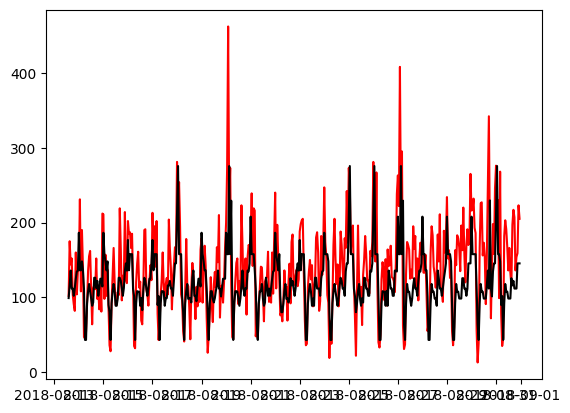

In [202]:
pred_4=pd.DataFrame(pred_4,index=target_test.index)
#plt.plot(target_train['2018-08-20':],color='blue')
plt.plot(target_test,color='red')
plt.plot(pred_4,color='black')
plt.show()

In [203]:
joblib.dump(model_2,'models/model_2.joblib')

['models/model_2.joblib']

## RandomForest y DesicionTree

In [204]:
# Comenzamos por los modelos sin potenciación del gradiente
pipe_rf=Pipeline([('rf',RandomForestRegressor())])
pipe_dt=Pipeline([('dt',DecisionTreeRegressor())])

params=[{'rf__max_depth':[3,4,2,1],
         'rf__min_samples_split':[5,10,11,12],
         'rf__n_estimators':[10,20,30,40],
         'rf__min_samples_leaf':[1, 2, 4],
         'rf__bootstrap':[True, False],
         'rf__max_features':[np.random.randint(1, 11)]},
         {'dt__max_depth': [3,4,2,1],
         'dt__max_features':[np.random.randint(1, 9)],
         'dt__min_samples_leaf': [1, 2, 4]},
         ]

In [205]:
#Entrenamos nuestros modelos

pipes=[pipe_rf,pipe_dt]
for pipe,grid in zip(pipes,params):
    rs=RandomizedSearchCV(estimator=pipe,param_distributions=grid,scoring='r2',cv=2,random_state=seed)
    rs.fit(features_train,target_train)
    print(rs.best_params_)
    print(rs.best_score_)
    print(rs.best_estimator_)
    random_prediction = rs.best_estimator_.predict(features_test)
    joblib.dump(rs.best_estimator_,f'models/model_{pipe}.joblib')
    random_rmse=mean_squared_error(target_test,random_prediction)**0.5
    print("RMSE:",random_rmse)

{'rf__n_estimators': 30, 'rf__min_samples_split': 11, 'rf__min_samples_leaf': 2, 'rf__max_features': 10, 'rf__max_depth': 4, 'rf__bootstrap': False}
0.04794028074986478
Pipeline(steps=[('rf',
                 RandomForestRegressor(bootstrap=False, max_depth=4,
                                       max_features=10, min_samples_leaf=2,
                                       min_samples_split=11,
                                       n_estimators=30))])
RMSE: 60.43871104007878
{'dt__min_samples_leaf': 2, 'dt__max_features': 6, 'dt__max_depth': 4}
0.031160697979929153
Pipeline(steps=[('dt',
                 DecisionTreeRegressor(max_depth=4, max_features=6,
                                       min_samples_leaf=2))])
RMSE: 57.88950334537097


## Conclusiones

1. La tendencia de los datos es hacia el més de agosto, va creciendo la demanda de serviciós hacia el final del año

2. La serie  no es estacional, debido a que tiene tendencia.

3. Al realizar la metodología Box-Jenkins, evidenciamos que la serie no es estacional. A pesar que la convertimos en estacional diferenciandola y evaluandola con los modelos ARIMA, el error fue mayor a 48 (58 aproximadamente). Adicionalmente se probó el Auto arima que mejoró representativamente nuestro resultado, sin embargo, no pasa la prueba del ejercicio.

4. Al desarrollar los modelos de predicción de la serie temporal, los modelos que mejor error tuvieron fue el Light_gbm, el CatBoost y el XGBoost, con errores de 43.90, 47.06 y 50.73 respectivamente. Se debe tener en cuenta que al tener solo el 10% de los datos para prueba, es más complejo obtener un error menor.

5. Los modelos que pasaron la prueba de obtener un error inferior a 48 fueron el Light_gbm y el CatBoost. Los demás modelos tuvieron errores superiores, los cuales son: XGBoost, LinearRegression, RandomForestRegressor y DesicionTreeRegressor.